In [1]:
import os, glob
from PIL import Image
import numpy as np
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

transform = transforms.Compose([
    transforms.ToTensor()
])

color_rules = {
    "data_vertical": 0,
    "kitchen_horizon": 0, 
    "kitchen_random": 0, 
    "kitchen_three": 7, 
    "kitchen_vertical": 0, 
    "layout1_practical": 1,
    "layout2_parallel": 1,
    "layout2_practical": 1,
    "layout3_practical": 1,
    "layout4_practical": 1,
    "layout5_line1": 1,
    "layout6_triangle": 1,
    "layout7_triangle2": 1,
    "layout8_line2": 1, 
    "layout9_vertical1": 1,
    "layout10_vertical1": 2,
    "layout11_vertical1": 3,
    "layout12_vertical1": 5,
    "layout13_vertical2": 1,
    "layout14_vertical2": 2,
    "layout15_horizon2": 1,
    "layout16_horizon2": 2,
    "layout17_horizon1": 2, 
    "layout18_horizon1": 1,
    "layout19_horizon1": 4,
    "layout20_horizon1": 5,
    "layout21_vertical": 6,
    "layout22_horizon": 6,
    "layout23_circle": 6
}

palette = [0,0,0,  128,0,0,  0,128,0,  128,128,0,  0,0,128,  128,0,128,  0,128,128,  128,128,128,
					 64,0,0,  192,0,0,  64,128,0,  192,128,0,  64,0,128,  192,0,128,  64,128,128,  192,128,128,
					 0,64,0,  128,64,0,  0,192,0,  128,192,0,  0,64,128,  128,64,128,  0,192,128,  128,192,128,
					 64,64,0,  192,64,0,  64,192,0, 192,192,0]
# forks, knives, spoons, plates, bowls, mugs, cups, cans, tables
all_colors = []
# data_vertical
all_colors.append(torch.tensor([[  172, 6,  64,  -1,  39, -1, -1, -1, -1,  28],
        [245, 187, 236, -1, 131, -1, -1, -1, -1, 209],
        [153, 233, 211, -1, 245, -1, -1, -1, -1, 226]]))
# layout1~9, 13, 15, 18*
all_colors.append(torch.tensor([[ 243, 54, 232, -1, 188, -1, -1, -1, -1, 35],
        [ 246, 200,  28,   -1, 154, -1, -1, -1, -1, 16],
        [ 208, 25, 225, -1, 128, -1, -1, -1, -1, 64]]))
# layout10, 14, 16~17*
all_colors.append(torch.tensor([[ 243, 54, 232, 235, 188, -1, -1, -1, -1, 35],
        [ 246, 200,  28,   57, 154, -1, -1, -1, -1, 16],
        [ 208, 25, 225, 90, 128, -1, -1, -1, -1, 64]]))
# layout11*
all_colors.append(torch.tensor([[ 243, 54, 232, 20, 188, 235, -1, -1, -1, 35],
        [ 246, 200,  28, 182, 154,   57, -1, -1, -1, 16],
        [ 208, 25, 225, 193, 128, 90, -1, -1, -1, 64]]))
# layout19*
all_colors.append(torch.tensor([[ 243, 54, 232, -1, 188, 235, -1, -1, -1, 35],
        [ 246, 200,  28, -1, 154,   57, -1, -1, -1, 16],
        [ 208, 25, 225, -1, 128, 90, -1, -1, -1, 64]]))
# layout12, 20*
all_colors.append(torch.tensor([[ 243, -1, -1, -1, 188, 54, 232, -1, -1, 35],
        [ 246, -1, -1,   -1, 154, 200,  28, -1, -1, 16],
        [ 208, -1, -1, -1, 128, 25, 225, -1, -1, 64]]))
# layout21~23*
all_colors.append(torch.tensor([[ 243, -1, -1, -1, -1, 188, 54, 232, 235, 35],
        [ 246, -1, -1,   -1, -1, 154, 200,  28, 57, 16],
        [ 208, -1, -1, -1, -1, 128, 25, 225, 90, 64]]))
# kitchen_three
all_colors.append(torch.tensor([[  172, 6,  64,  47,  39, -1, -1, -1, -1,  28],
        [245, 187, 236, 120, 131, -1, -1, -1, -1, 209],
        [153, 233, 211, 247, 245, -1, -1, -1, -1, 226]]))

for file in glob.glob("datasets/YCB_kitchen_data/layout*/**/*_seg.png", recursive=True):
    image = Image.open(file)
    image = (transform(image) * 255).int()
    colors = all_colors[color_rules[file.split("/")[2]]]
    # print(torch.unique(image.reshape(image.shape[0], -1), dim=1))
    mask = torch.zeros_like(image[[0]])
    for i in range(colors.shape[1]):
        if i < 9:
             index = i
        else:
             index = 14
        mask[torch.all(((image - colors[:, [i]].unsqueeze(2)) == 0), dim=0).unsqueeze(0)] = index
    mask = transforms.ToPILImage()(mask.type(torch.uint8)).convert("P")
    mask.putpalette(palette)
    out_dirname = "./data"
    begin = False
    for dirs in os.path.dirname(file).split("/"):
        if begin:
            out_dirname = os.path.join(out_dirname, dirs)
        if dirs == "datasets":
            begin = True
    os.makedirs(out_dirname, exist_ok=True)
    mask.save(os.path.join(out_dirname, os.path.basename(file)))
#     break

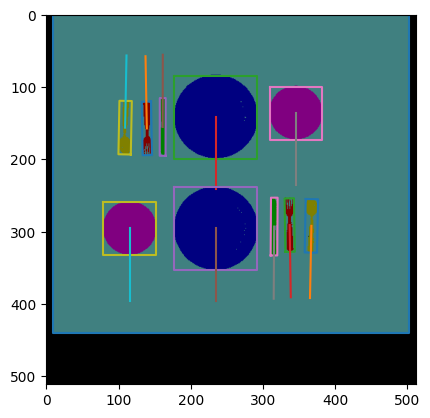

In [3]:
import os, glob
from PIL import Image
import numpy as np
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import cv2

orientation_rules = {
    "data_vertical": {"vertical": "all_down", "horizon": "no_preference"}, 
    "kitchen_horizon": {"vertical": "no_preference", "horizon": "all_right"},
    "kitchen_random": {"vertical": "all_down", "horizon": "all_right"},
    "kitchen_three": {"vertical": "all_down", "horizon": "all_right"},
    "kitchen_vertical": {"vertical": "all_down", "horizon": "no_preference"},
    "layout1_practical": {"vertical": "to_center", "horizon": "no_preference"},
    "layout2_parallel": {"vertical": "to_center", "horizon": "no_preference"},
    "layout2_practical": {"vertical": "to_center", "horizon": "no_preference"},
    "layout3_practical": {"vertical": "to_center", "horizon": "to_center"},
    "layout4_practical": {"vertical": "to_center", "horizon": "to_center"},
    "layout5_line1": {"vertical": "all_down", "horizon": "to_center"},
    "layout6_triangle": {"vertical": "all_down", "horizon": "to_center"},
    "layout7_triangle2": {"vertical": "all_down", "horizon": "to_center"},
    "layout8_line2": {"vertical": "no_preference", "horizon": "all_right"}, 
    "layout9_vertical1": {"vertical": "to_center", "horizon": "no_preference"},
    "layout10_vertical1": {"vertical": "to_center", "horizon": "no_preference"},
    "layout11_vertical1": {"vertical": "to_center", "horizon": "no_preference"},
    "layout12_vertical1": {"vertical": "force_down", "horizon": "no_preference"},
    "layout13_vertical2": {"vertical": "to_center", "horizon": "no_preference"},
    "layout14_vertical2": {"vertical": "to_center", "horizon": "all_right"},
    "layout15_horizon2": {"vertical": "no_preference", "horizon": "to_center"},
    "layout16_horizon2": {"vertical": "anticlockwise", "horizon": "to_center"},
    "layout17_horizon1": {"vertical": "no_preference", "horizon": "to_center"}, 
    "layout18_horizon1": {"vertical": "no_preference", "horizon": "to_center"},
    "layout19_horizon1": {"vertical": "no_preference", "horizon": "to_center"},
    "layout20_horizon1": {"vertical": "force_anticlockwise", "horizon": "no_preference"},
    "layout21_vertical": {"vertical": "force_down", "horizon": "no_preference"},
    "layout22_horizon": {"vertical": "force_down", "horizon": "no_preference"},
    "layout23_circle": {"vertical": "force_down", "horizon": "no_preference"}
}

transform = transforms.Compose([
    transforms.ToTensor()
])

pca = PCA(n_components=2)

for file in glob.glob("data/YCB_kitchen_data/**/*_seg.png", recursive=True):
    image = Image.open(file).convert("P")
    o_rule = orientation_rules[file.split("/")[2]]
    v_rule = o_rule["vertical"]
    h_rule = o_rule["horizon"]
    w, h = image.size
    plt.imshow(image)
    image = (transform(image) * 255).int()
    scene = {}
    for category in range(1, 15):
        if category == 14:
            index = torch.where(image == category)
            if len(index[0]) > 10:
                index = list(zip(2 * index[1].numpy() / (h - 1) - 1, 2 * index[2].numpy() / (w - 1) - 1))
                up = min(index, key=lambda x: x[0])[0]
                bottom = max(index, key=lambda x: x[0])[0]
                left = min(index, key=lambda x: x[1])[1]
                right = max(index, key=lambda x: x[1])[1]
                bbox = torch.tensor([[up, left], [up, right], [bottom, right], [bottom, left]])
                bbox_w, bbox_h = right - left, bottom - up
                scene[category] = [{"img_size": torch.tensor([h, w]), "bbox": bbox, "bbox_size": torch.tensor([bbox_h, bbox_w]) - 1, "type": torch.LongTensor([1])}]
                bbox = (bbox + 1) * (torch.tensor([[h, w]]) - 1) / 2
                bbox_mean = torch.mean(bbox.float(), dim=0)
                bbox = torch.cat([bbox, bbox[[0]]])
                plt.plot(bbox[:, 1], bbox[:, 0])
        else:
            index = (image == category).type(torch.uint8)
            objects, labels, stats, _ = cv2.connectedComponentsWithStats(index[0].numpy(), connectivity=8)
            if objects > 1:
                scene[category] = []
            for i in range(1, objects):
                index = torch.where(torch.from_numpy(labels).unsqueeze(0) == i)
                if len(index[0]) > 10:
                    index = list(zip(2 * index[1].numpy() / (h - 1) - 1, 2 * index[2].numpy() / (w - 1) - 1))
                    index_mean = np.mean(index, axis=0)
                    index = index - index_mean
                    pca.fit(index)
                    if pca.explained_variance_ratio_[0] > pca.explained_variance_ratio_[1] + 0.1:
                        new_index = pca.transform(index)
                        up = min(new_index, key=lambda x: x[0])[0]
                        bottom = max(new_index, key=lambda x: x[0])[0]
                        left = min(new_index, key=lambda x: x[1])[1]
                        right = max(new_index, key=lambda x: x[1])[1]
                        bbox = torch.tensor([[up, left], [up, right], [bottom, right], [bottom, left]])
                        bbox_w, bbox_h = right - left, bottom - up
                        bbox = torch.from_numpy(pca.inverse_transform(bbox) + index_mean)
                        orientation = torch.from_numpy(pca.components_[0])
                    else:
                        new_index = index + index_mean
                        up = min(new_index, key=lambda x: x[0])[0]
                        bottom = max(new_index, key=lambda x: x[0])[0]
                        left = min(new_index, key=lambda x: x[1])[1]
                        right = max(new_index, key=lambda x: x[1])[1]
                        bbox = torch.tensor([[up, left], [up, right], [bottom, right], [bottom, left]])
                        bbox_w, bbox_h = right - left, bottom - up
                        orientation = torch.tensor([1, 0])
                    orientation = torch.nn.functional.normalize(orientation.float(), dim=0)
                    if category in [1, 2, 3, 6, 7, 8]:
                        theta = torch.atan2(orientation[1], orientation[0])
                        bbox_mean = torch.mean(bbox.float(), dim=0)
                        if v_rule == "to_center":
                            if (theta > 2.5 or theta < -2.5) and bbox_mean[0] > 0:
                                orientation = -orientation
                            if -0.5 < theta < 0.5 and bbox_mean[0] < 0:
                                orientation = -orientation
                        elif v_rule == "anticlockwise":
                            if (theta > 2.5 or theta < -2.5) and bbox_mean[1] > 0:
                                orientation = -orientation
                            if -0.5 < theta < 0.5 and bbox_mean[1] < 0:
                                orientation = -orientation
                        elif v_rule == "all_up":
                            if -0.5 < theta < 0.5:
                                orientation = -orientation
                        elif v_rule == "all_down":
                            if theta > 2.5 or theta < -2.5:
                                orientation = -orientation
                        elif v_rule == "force_anticlockwise":
                            new_index = index + index_mean
                            up = min(new_index, key=lambda x: x[0])[0]
                            bottom = max(new_index, key=lambda x: x[0])[0]
                            left = min(new_index, key=lambda x: x[1])[1]
                            right = max(new_index, key=lambda x: x[1])[1]
                            bbox = torch.tensor([[up, left], [up, right], [bottom, right], [bottom, left]])
                            bbox_w, bbox_h = right - left, bottom - up
                            orientation = torch.tensor([1, 0])
                            if bbox_mean[1] > 0:
                                orientation = -orientation
                        elif v_rule == "force_down":
                            new_index = index + index_mean
                            up = min(new_index, key=lambda x: x[0])[0]
                            bottom = max(new_index, key=lambda x: x[0])[0]
                            left = min(new_index, key=lambda x: x[1])[1]
                            right = max(new_index, key=lambda x: x[1])[1]
                            bbox = torch.tensor([[up, left], [up, right], [bottom, right], [bottom, left]])
                            bbox_w, bbox_h = right - left, bottom - up
                            orientation = torch.tensor([1, 0])
                        if h_rule == "to_center":
                            if 2 > theta > 1 and bbox_mean[1] < 0:
                                orientation = -orientation
                            if -2 < theta < -1 and bbox_mean[1] > 0:
                                orientation = -orientation
                        elif h_rule == "all_left":
                            if 2 > theta > 1:
                                orientation = -orientation
                        elif h_rule == "all_right":
                            if -2 < theta < -1:
                                orientation = -orientation
                    scene[category].append({"img_size": torch.tensor([h, w]), "bbox": bbox, "bbox_size": torch.tensor([bbox_h, bbox_w]) - 1, "orientation": orientation})
                    bbox = (bbox + 1) * (torch.tensor([[h, w]]) - 1) / 2
                    bbox_mean = torch.mean(bbox.float(), dim=0)
                    orientation = bbox_mean + orientation * 100
                    bbox = torch.cat([bbox, bbox[[0]]])
                    plt.plot(bbox[:, 1], bbox[:, 0])
                    plt.plot([bbox_mean[1], orientation[1]], [bbox_mean[0], orientation[0]])
    # torch.save(scene, os.path.join(os.path.dirname(file), os.path.basename(file).split(".")[0] + ".pt"))
    # mask = torch.zeros_like(image)
    # mask[image == category] = 1
    # mask = transforms.ToPILImage()(mask.type(torch.uint8))
    # plt.imshow(mask, cmap="gray")
    break

In [ ]:
import os, glob, json
from PIL import Image
import numpy as np
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

transform = transforms.Compose([
    transforms.ToTensor()
])

color_rules = {
    "layout1": {
        "shape1": 0,
        "shape2": 0,
        "shape3": 0, 
        "shape4": 1, 
        "shape5": 0
    }, 
    "layout2": {
        "shape1": 0,
        "shape2": 0,
        "shape3": 0
    }, 
    "layout3": {
        "shape1": 0,
        "shape2": 0,
        "shape3": 1,
        "shape4": 2, 
        "shape5": 3, 
        "shape6": 4, 
        "shape7": 5, 
        "shape8": 6, 
        "shape9": 2, 
        "shape10": 7, 
        "shape11": 8, 
        "shape12": 9, 
        "shape13": 10
    }, 
    "layout4": {
        "shape1": 0,
        "shape2": 1,
        "shape3": 2,
        "shape4": 0, 
        "shape5": 1, 
        "shape6": 2
    }
}

palette = [0,0,0,  128,0,0,  0,128,0,  128,128,0,  0,0,128,  128,0,128,  0,128,128,  128,128,128,
					 64,0,0,  192,0,0,  64,128,0,  192,128,0,  64,0,128,  192,0,128,  64,128,128,  192,128,128,
					 0,64,0,  128,64,0,  0,192,0,  128,192,0,  0,64,128,  128,64,128,  0,192,128,  128,192,128,
					 64,64,0,  192,64,0,  64,192,0, 192,192,0]
# forks, knives, spoons, plates, bowls, mugs, cups, cans, boxes, bottles, bananas, berries, mask, table
all_colors = {}
layout_colors = []
# shape1~3, 5
layout_colors.append(torch.tensor([[  243, -1, -1, -1, -1, -1, -1, -1, 188,  54, -1, -1, -1, -1, -1, 0,  35],
        [  246, -1, -1, -1, -1, -1, -1, -1, 154, 200, -1, -1, -1, -1, -1,  0,  16],
        [  208, -1, -1, -1, -1, -1, -1, -1, 128,  25, -1, -1, -1, -1, -1,  0,  64]]))
# shape4
layout_colors.append(torch.tensor([[  243, -1, -1, -1, -1, -1, -1, -1, 188, 232,  54, -1, -1,  -1, -1, 0,  35],
        [  246, -1, -1, -1, -1, -1, -1, -1, 154,  28, 200, -1,  -1, -1, -1, 0,  16],
        [  208, -1, -1, -1, -1, -1, -1, -1, 128, 225,  25, -1,  -1, -1, -1, 0,  64]]))
all_colors["layout1"] = layout_colors
layout_colors = []
# shape1~3
layout_colors.append(torch.tensor([[  243, -1, -1, -1, -1, -1, -1, -1, 188,  54, -1, -1, -1, -1, -1, 0,  35],
        [  246, -1, -1, -1, -1, -1, -1, -1, 154, 200, -1, -1, -1, -1, -1,  0,  16],
        [  208, -1, -1, -1, -1, -1, -1, -1, 128,  25, -1, -1, -1, -1, -1,  0,  64]]))
all_colors["layout2"] = layout_colors
layout_colors = []
# shape1~2
layout_colors.append(torch.tensor([[  243, -1, -1, -1, -1, -1, -1, -1, 188, -1, -1,  54, -1, -1, -1, 0,  35],
        [  246, -1, -1, -1, -1, -1, -1, -1, 154, -1, -1, 200, -1, -1, -1, 0,  16],
        [  208, -1, -1, -1, -1, -1, -1, -1, 128, -1, -1,  25, -1, -1, -1, 0,  64]]))
# shape3
layout_colors.append(torch.tensor([[  243, -1, -1, -1, -1, -1, -1, -1, 188, -1, -1,  54, 232, -1, -1, 0,  35],
        [  246, -1, -1, -1, -1, -1, -1, -1, 154, -1, -1, 200, 28, -1, -1,  0,  16],
        [  208, -1, -1, -1, -1, -1, -1, -1, 128, -1, -1,  25, 225, -1, -1,  0,  64]]))
# shape4, 9
layout_colors.append(torch.tensor([[  243, -1, -1, -1, -1, -1, -1, -1, 188, -1, -1,  54, 232, 235,  20, 0,  35],
        [  246, -1, -1, -1, -1, -1, -1, -1, 154, -1, -1, 200,  28,  57, 182, 0,  16],
        [  208, -1, -1, -1, -1, -1, -1, -1, 128, -1, -1,  25, 225,  90, 193, 0,  64]]))
# shape5
layout_colors.append(torch.tensor([[  243, -1, -1, -1, -1, -1, -1, -1, -1, 188, -1,  54, -1, -1, -1, 0,  35],
        [  246, -1, -1, -1, -1, -1, -1, -1, -1, 154, -1, 200, -1, -1, -1, 0,  16],
        [  208, -1, -1, -1, -1, -1, -1, -1, -1, 128, -1,  25, -1, -1, -1, 0,  64]]))
# shape6
layout_colors.append(torch.tensor([[  243, -1, -1, -1, -1, -1, -1, -1, -1, 188, -1,  54, 232, -1, -1, 0,  35],
        [  246, -1, -1, -1, -1, -1, -1, -1, -1, 154, -1, 200, 28, -1, -1,  0,  16],
        [  208, -1, -1, -1, -1, -1, -1, -1, -1, 128, -1,  25, 225, -1, -1,  0,  64]]))
# shape7
layout_colors.append(torch.tensor([[  243, -1, -1, -1, -1, -1, -1, -1, -1, 188, -1,  54, 232, -1,  -1, 0,  35],
        [  246, -1, -1, -1, -1, -1, -1, -1, -1, 154, -1, 200,  28,  -1, -1, 0,  16],
        [  208, -1, -1, -1, -1, -1, -1, -1, -1, 128, -1,  25, 225,  -1, -1, 0,  64]]))
# shape8
layout_colors.append(torch.tensor([[  243, -1, -1, -1, -1, -1, -1, -1, 188,  54, -1, 232, 235,  20, 8, 0,  35],
        [  246, -1, -1, -1, -1, -1, -1, -1, 154, 200, -1,  28,  57, 182, 94, 0,  16],
        [  208, -1, -1, -1, -1, -1, -1, -1, 128,  25, -1, 225,  90, 193, 186, 0,  64]]))
# shape10
layout_colors.append(torch.tensor([[  243, -1, -1, -1, -1, -1, -1, -1, 188, -1, -1,  54, 232, -1,  -1, 0,  35],
        [  246, -1, -1, -1, -1, -1, -1, -1, 154, -1, -1, 200,  28,  -1, -1, 0,  16],
        [  208, -1, -1, -1, -1, -1, -1, -1, 128, -1, -1,  25, 225,  -1, -1, 0,  64]]))
# shape11
layout_colors.append(torch.tensor([[  243, -1, -1, -1, -1, -1, -1, -1, -1, 188, -1, 232,  54, 235,  -1, 0,  35],
        [  246, -1, -1, -1, -1, -1, -1, -1, -1, 154, -1,  28, 200,  57, -1, 0,  16],
        [  208, -1, -1, -1, -1, -1, -1, -1, -1, 128, -1, 225,  25,  90, -1, 0,  64]]))
# shape12
layout_colors.append(torch.tensor([[  243, -1, -1, -1, -1, -1, -1, -1, -1, 188, -1,  54, 232, 235,  -1, 0,  35],
        [  246, -1, -1, -1, -1, -1, -1, -1, -1, 154, -1, 200,  28,  57, -1, 0,  16],
        [  208, -1, -1, -1, -1, -1, -1, -1, -1, 128, -1,  25, 225,  90, -1, 0,  64]]))
# shape13
layout_colors.append(torch.tensor([[  243, -1, -1, -1, -1, -1, -1, -1, 188,  54, -1, 232, 235,  -1, -1, 0,  35],
        [  246, -1, -1, -1, -1, -1, -1, -1, 154, 200, -1,  28,  57, -1, -1, 0,  16],
        [  208, -1, -1, -1, -1, -1, -1, -1, 128,  25, -1, 225,  90, -1, -1, 0,  64]]))
all_colors["layout3"] = layout_colors
layout_colors = []
# shape1
layout_colors.append(torch.tensor([[  243, -1, -1, -1, -1, -1, -1, -1, 188,  -1, -1, -1, -1, -1, -1, 0,  35],
        [  246, -1, -1, -1, -1, -1, -1, -1, 154, -1, -1, -1, -1, -1, -1,  0,  16],
        [  208, -1, -1, -1, -1, -1, -1, -1, 128,  -1, -1, -1, -1, -1, -1,  0,  64]]))
# shape2
layout_colors.append(torch.tensor([[  243, -1, -1, -1, -1, -1, -1, -1, 188,  54, -1, -1, -1, -1, -1, 0,  35],
        [  246, -1, -1, -1, -1, -1, -1, -1, 154, 200, -1, -1, -1, -1, -1,  0,  16],
        [  208, -1, -1, -1, -1, -1, -1, -1, 128,  25, -1, -1, -1, -1, -1,  0,  64]]))
# shape3
layout_colors.append(torch.tensor([[  243, -1, -1, -1, -1, -1, -1, -1, 188,  54, 232, -1, -1, -1, -1, 0,  35],
        [  246, -1, -1, -1, -1, -1, -1, -1, 154, 200, 28, -1, -1, -1, -1,  0,  16],
        [  208, -1, -1, -1, -1, -1, -1, -1, 128,  25, 225, -1, -1, -1, -1,  0,  64]]))
all_colors["layout4"] = layout_colors

category_index = {
    "fork": 1, "knife": 2, "spoon": 3, "plate": 4, "bowl": 5, "mug": 6, "cup": 7, "can": 8, "box": 9, "bottle": 10, "banana": 11, "berry": 12
    }
category = {}
with open("datasets/YCB_Inpainted_data/layout4/category.json") as f:
    category_match = json.load(f)
category["layout4"] = category_match

for file in glob.glob("datasets/YCB_Inpainted_data/**/*_seg.png", recursive=True):
    image = Image.open(file)
    image = (transform(image) * 255).int()
    layout = file.split("/")[2]
    shape = file.split("/")[3]
    colors = all_colors[layout][color_rules[layout][shape]]
#     print(torch.unique(image.reshape(image.shape[0], -1), dim=1))
    mask = torch.zeros_like(image[[0]])
    for i in range(colors.shape[1]):
        if (layout == "layout1" and shape == "shape5") or (layout == "layout2" and shape == "shape3"):
            if i == 0:
                index = i
            elif 8 <= i <= 9:
                index = 18 - i
            else:
                index = i - 2
        elif (layout == "layout3" and shape == "shape7") or (layout == "layout3" and shape == "shape10") or (layout == "layout3" and shape == "shape13"):
            if 0 <= i <= 10:
                index = i
            elif 11 <= i <= 14:
                index = 12
            else:
                index = i - 2
        elif layout == "layout4":
            if 0 <= i <= 7:
                index = i
            elif 8 <= i <= 10:
                category_match = category[layout][shape][file.split("/")[4].split(".")[0]]
                if i - 8 < len(category_match):
                    index = category_index[category_match[i - 8]]
                else:
                    index = 0
            else:
                index = i - 2
        else:
            if 0 <= i <= 11:
                index = i
            elif 12 <= i <= 14:
                index = 12
            else:
                index = i - 2
        mask[torch.all(((image - colors[:, [i]].unsqueeze(2)) == 0), dim=0).unsqueeze(0)] = index
    mask = transforms.ToPILImage()(mask.type(torch.uint8)).convert("P")
    mask.putpalette(palette)
    out_dirname = "./data"
    begin = False
    for dirs in os.path.dirname(file).split("/"):
        if begin:
            out_dirname = os.path.join(out_dirname, dirs)
        if dirs == "datasets":
            begin = True
    os.makedirs(out_dirname, exist_ok=True)
    mask.save(os.path.join(out_dirname, os.path.basename(file)))
    # break

In [ ]:
import os, glob
from PIL import Image
import numpy as np
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import cv2

orientation_rules = {
    "layout1" : {
        "shape1": {"vertical": "force_down", "horizon": "force_right"}, 
        "shape2": {"vertical": "force_down", "horizon": "force_right"},
        "shape3": {"vertical": "force_down", "horizon": "force_right"},
        "shape4": {"vertical": "force_down", "horizon": "force_right"},
        "shape5": {"vertical": "all_down", "horizon": "force_right"}
    }, 
    "layout2" : {
        "shape1": {"vertical": "force_down", "horizon": "force_right"}, 
        "shape2": {"vertical": "force_down", "horizon": "force_right"},
        "shape3": {"vertical": "all_down", "horizon": "force_right"}
    }, 
    "layout3" : {
        "shape1": {"vertical": "force_down", "horizon": "all_right"}, 
        "shape2": {"vertical": "force_down", "horizon": "all_right"},
        "shape3": {"vertical": "force_down", "horizon": "all_right"},
        "shape4": {"vertical": "force_down", "horizon": "all_right"},
        "shape5": {"vertical": "no_preference", "horizon": "force_right"},
        "shape6": {"vertical": "force_down", "horizon": "force_right"},
        "shape7": {"vertical": "force_down", "horizon": "force_right"},
        "shape8": {"vertical": "force_down", "horizon": "force_right"}, 
        "shape9": {"vertical": "force_down", "horizon": "all_right"}, 
        "shape10": {"vertical": "force_down", "horizon": "no_preference"}, 
        "shape11": {"vertical": "force_down", "horizon": "force_right"}, 
        "shape12": {"vertical": "force_down", "horizon": "force_right"}, 
        "shape13": {"vertical": "force_down", "horizon": "force_right"}
    }, 
    "layout4" : {
        "shape1": {"vertical": "force_down", "horizon": "force_right"}, 
        "shape2": {"vertical": "force_down", "horizon": "force_right"},
        "shape3": {"vertical": "force_down", "horizon": "force_right"},
        "shape4": {"vertical": "force_down", "horizon": "no_preference"},
        "shape5": {"vertical": "force_down", "horizon": "all_right"},
        "shape6": {"vertical": "force_down", "horizon": "force_right"}
    }
}

transform = transforms.Compose([
    transforms.ToTensor()
])

pca = PCA(n_components=2)

for file in glob.glob("data/YCB_Inpainted_data/**/*_seg.png", recursive=True):
    image = Image.open(file).convert("P")
    layout = file.split("/")[2]
    shape = file.split("/")[3]
    o_rule = orientation_rules[layout][shape]
    v_rule = o_rule["vertical"]
    h_rule = o_rule["horizon"]
    w, h = image.size
    plt.imshow(image)
    image = (transform(image) * 255).int()
    scene = {}
    for category in range(1, 15):
        if category == 14:
            index = torch.where(image == category)
            if len(index[0]) > 10:
                index = list(zip(2 * index[1].numpy() / (h - 1) - 1, 2 * index[2].numpy() / (w - 1) - 1))
                up = min(index, key=lambda x: x[0])[0]
                bottom = max(index, key=lambda x: x[0])[0]
                left = min(index, key=lambda x: x[1])[1]
                right = max(index, key=lambda x: x[1])[1]
                bbox = torch.tensor([[up, left], [up, right], [bottom, right], [bottom, left]])
                bbox_w, bbox_h = right - left, bottom - up
                scene[category] = [{"img_size": torch.tensor([h, w]), "bbox": bbox, "bbox_size": torch.tensor([bbox_h, bbox_w]) - 1, "type": torch.LongTensor([1])}]
                bbox = (bbox + 1) * (torch.tensor([[h, w]]) - 1) / 2
                bbox_mean = torch.mean(bbox.float(), dim=0)
                bbox = torch.cat([bbox, bbox[[0]]])
                plt.plot(bbox[:, 1], bbox[:, 0])
        elif category == 13:
            index = (image == category).type(torch.uint8)
            objects, labels, stats, _ = cv2.connectedComponentsWithStats(index[0].numpy(), connectivity=4)
            if objects > 1:
                scene[category] = []
            for i in range(1, objects):
                index = torch.where(torch.from_numpy(labels).unsqueeze(0) == i)
                if len(index[0]) > 10:
                    index = list(zip(2 * index[1].numpy() / (h - 1) - 1, 2 * index[2].numpy() / (w - 1) - 1))
                    up = min(index, key=lambda x: x[0])[0]
                    bottom = max(index, key=lambda x: x[0])[0]
                    left = min(index, key=lambda x: x[1])[1]
                    right = max(index, key=lambda x: x[1])[1]
                    bbox = torch.tensor([[up, left], [up, right], [bottom, right], [bottom, left]])
                    bbox_w, bbox_h = right - left, bottom - up
                    if np.abs(bbox_w - bbox_h) > 0.05:
                        mask_type = 2
                    else:
                        mask_type = 3
                    scene[category].append({"img_size": torch.tensor([h, w]), "bbox": bbox, "bbox_size": torch.tensor([bbox_h, bbox_w]) - 1, "type": torch.LongTensor([mask_type])})
                    bbox = (bbox + 1) * (torch.tensor([[h, w]]) - 1) / 2
                    bbox_mean = torch.mean(bbox.float(), dim=0)
                    bbox = torch.cat([bbox, bbox[[0]]])
                    plt.plot(bbox[:, 1], bbox[:, 0])
        else:
            index = (image == category).type(torch.uint8)
            objects, labels, stats, _ = cv2.connectedComponentsWithStats(index[0].numpy(), connectivity=4)
            if objects > 1:
                scene[category] = []
            for i in range(1, objects):
                index = torch.where(torch.from_numpy(labels).unsqueeze(0) == i)
                if len(index[0]) > 10:
                    index = list(zip(2 * index[1].numpy() / (h - 1) - 1, 2 * index[2].numpy() / (w - 1) - 1))
                    index_mean = np.mean(index, axis=0)
                    index = index - index_mean
                    pca.fit(index)
                    if pca.explained_variance_ratio_[0] > pca.explained_variance_ratio_[1] + 0.1:
                        new_index = pca.transform(index)
                        up = min(new_index, key=lambda x: x[0])[0]
                        bottom = max(new_index, key=lambda x: x[0])[0]
                        left = min(new_index, key=lambda x: x[1])[1]
                        right = max(new_index, key=lambda x: x[1])[1]
                        bbox = torch.tensor([[up, left], [up, right], [bottom, right], [bottom, left]])
                        bbox_w, bbox_h = right - left, bottom - up
                        bbox = torch.from_numpy(pca.inverse_transform(bbox) + index_mean)
                        orientation = torch.from_numpy(pca.components_[0])
                    else:
                        new_index = index + index_mean
                        up = min(new_index, key=lambda x: x[0])[0]
                        bottom = max(new_index, key=lambda x: x[0])[0]
                        left = min(new_index, key=lambda x: x[1])[1]
                        right = max(new_index, key=lambda x: x[1])[1]
                        bbox = torch.tensor([[up, left], [up, right], [bottom, right], [bottom, left]])
                        bbox_w, bbox_h = right - left, bottom - up
                        orientation = torch.tensor([1, 0])
                    orientation = torch.nn.functional.normalize(orientation.float(), dim=0)
                    if category in [1, 2, 3, 8, 9, 10, 11, 12]:
                        theta = torch.atan2(orientation[1], orientation[0])
                        bbox_mean = torch.mean(bbox.float(), dim=0)
                        if v_rule == "all_up":
                            if -0.5 < theta < 0.5:
                                orientation = -orientation
                        elif v_rule == "all_down":
                            if theta > 2.5 or theta < -2.5:
                                orientation = -orientation
                        elif v_rule == "force_down":
                            if theta > 2.5 or theta < -2.5:
                                orientation = -orientation
                            if category in [8, 12]:
                                new_index = index + index_mean
                                up = min(new_index, key=lambda x: x[0])[0]
                                bottom = max(new_index, key=lambda x: x[0])[0]
                                left = min(new_index, key=lambda x: x[1])[1]
                                right = max(new_index, key=lambda x: x[1])[1]
                                bbox = torch.tensor([[up, left], [up, right], [bottom, right], [bottom, left]])
                                bbox_w, bbox_h = right - left, bottom - up
                                orientation = torch.tensor([1, 0])
                        theta = torch.atan2(orientation[1], orientation[0])
                        if h_rule == "all_right":
                            if -2 < theta < -1:
                                orientation = -orientation
                        elif h_rule == "force_right":
                            if -2 < theta < -1:
                                orientation = -orientation
                            if category in [9]:
                                # if theta > 2.5 or theta < -2.5:
                                #     orientation = torch.tensor([-orientation[1], orientation[0]])
                                # elif -0.5 < theta < 0.5:
                                #     orientation = torch.tensor([orientation[1], -orientation[0]])
                                new_index = index + index_mean
                                up = min(new_index, key=lambda x: x[0])[0]
                                bottom = max(new_index, key=lambda x: x[0])[0]
                                left = min(new_index, key=lambda x: x[1])[1]
                                right = max(new_index, key=lambda x: x[1])[1]
                                bbox = torch.tensor([[up, left], [up, right], [bottom, right], [bottom, left]])
                                bbox_w, bbox_h = right - left, bottom - up
                                bbox_h, bbox_w = bbox_w, bbox_h
                                orientation = torch.tensor([0, 1])
                    scene[category].append({"img_size": torch.tensor([h, w]), "bbox": bbox, "bbox_size": torch.tensor([bbox_h, bbox_w]) - 1, "orientation": orientation})
                    bbox = (bbox + 1) * (torch.tensor([[h, w]]) - 1) / 2
                    bbox_mean = torch.mean(bbox.float(), dim=0)
                    orientation = bbox_mean + orientation * 100
                    bbox = torch.cat([bbox, bbox[[0]]])
                    plt.plot(bbox[:, 1], bbox[:, 0])
                    plt.plot([bbox_mean[1], orientation[1]], [bbox_mean[0], orientation[0]])
    # torch.save(scene, os.path.join(os.path.dirname(file), os.path.basename(file).split(".")[0] + ".pt"))
    # mask = torch.zeros_like(image)
    # mask[image == category] = 1
    # mask = transforms.ToPILImage()(mask.type(torch.uint8))
    # plt.imshow(mask, cmap="gray")
    break

In [ ]:
from scripts.dataset import TableDataset
import torch
import numpy as np
from scripts.utils import visual_noise, visual_noise_denoise
from scripts.noise_schedule import NoiseSchedule
from omegaconf import OmegaConf

data_config = OmegaConf.load("configs/YCB_Inpainted.yaml")

dataset = TableDataset(path=[data_config["dataset_path"]], num_class=data_config["num_class"])
schedule = NoiseSchedule(1000)
t = torch.randint(0, schedule.timesteps, (1,), dtype=torch.long)
input, mask, cond, word, labels, padding_mask, _, clean_scenepaths = dataset.gen_kitchen(1, t, schedule, data_augment=1, random_idx=np.array([0]), data_partition="test", use_move_less=True, no_rotate_class=data_config["no_rotate_class"], static_class=[], same_class=[], floorplan_class=data_config["floorplan_class"], within_floorplan=True, no_penetration=False, noise_level_stddev=0.5, angle_noise_level_stddev=np.pi/3)
input = torch.tensor(input)
mask = torch.tensor(mask)
labels = torch.tensor(labels)
padding_mask = torch.tensor(padding_mask)

idx = 0
target_bbox = [(bbox_y, bbox_x, bbox_h + 1, bbox_w + 1, bbox_type.int().item()) for bbox_y, bbox_x, _, _, bbox_h, bbox_w, bbox_type in mask[idx]]
visual_noise_denoise(clean_scenepaths[idx], input[idx], labels[idx], padding_mask[idx], target_bbox=target_bbox)
# visual_noise(clean_scenepaths[idx], input[idx], padding_mask[idx], target_bbox=target_bbox)

In [10]:
import glob, os, copy
import torch
import numpy as np
from scripts.model import Denoiser
from scripts.dataset import TableDataset
from scripts.noise_schedule import NoiseSchedule
from train import denoise_1scene, adjust_parameters
from omegaconf import OmegaConf

# data_config = OmegaConf.load("configs/YCB_kitchen.yaml")
data_config = OmegaConf.load("configs/YCB_Inpainted.yaml")

dataset = TableDataset(path=[data_config["dataset_path"]], num_class=data_config["num_class"])
schedule = NoiseSchedule(1000)
predict_absolute_pos = 1
predict_absolute_ang = 1
noise_level_stddev=1.0
angle_noise_level_stddev=np.pi / 3
t = torch.randint(0, schedule.timesteps, (1,), dtype=torch.long)
input, mask, cond, word, labels, padding_mask, mask_padding_mask, clean_scenepaths = dataset.gen_kitchen(1, t, schedule, random_idx=np.array([0]), abs_pos=predict_absolute_pos, abs_ang=predict_absolute_ang, data_partition="test", no_rotate_class=data_config["no_rotate_class"], static_class=[], same_class=[], floorplan_class=data_config["floorplan_class"], within_floorplan=True, no_penetration=False, noise_level_stddev=noise_level_stddev, angle_noise_level_stddev=angle_noise_level_stddev)
bbox_means, orientations, bbox_sizes = input[:, :, :2], input[:, :, 2:4], input[:, :, 4:6]
input = torch.tensor(input)
mask = torch.tensor(mask)
word = torch.tensor(word)
labels = torch.tensor(labels)
padding_mask = torch.tensor(padding_mask)
mask_padding_mask = torch.tensor(mask_padding_mask)

use_position = False
use_time = False
use_text = True
time_form="add"
text_form="word"
denoiser = Denoiser(cla_dim=dataset.cla_dim, max_position=dataset.maxnobj, time_form=time_form, text_form=text_form, mask_types=data_config["mask_types"], use_position = use_position, use_time = use_time, use_text = use_text, cla_initial_unit = [128, 128], all_initial_unit = [512, 512], pe_numfreq = 32)
if use_text:
    if text_form == "word":
        cond = None
        un_cond = None
    elif text_form == "sentence":
        # cond = ['Knives and forks are placed on the same side of the plates, while four plates are placed horizontally in a row.']
        cond = denoiser.encode_cond(cond, input.device)
        un_cond = denoiser.encode_cond(input.shape[0] * [""], input.device)
        word = None
else:
    cond = None
    un_cond = None
    word = None

In [13]:
for old_best_checkpoint in glob.glob(os.path.join("./logs/YCB_Inpainted/0129_112514_562__FTFFFT_", "best*")):
    # checkpoint = torch.load(old_best_checkpoint, map_location="cuda:0")
    checkpoint = torch.load(old_best_checkpoint, map_location="cpu")
    break
denoiser.load_state_dict(checkpoint['model_state_dict'])

args = {}
args["device"] = input.device
args['predict_absolute_pos'] = predict_absolute_pos
args['predict_absolute_ang'] = predict_absolute_ang
args['train_pos_noise_level_stddev'] = noise_level_stddev
args['train_ang_noise_level_stddev'] = angle_noise_level_stddev

# word = torch.LongTensor([[1, 2]])
# cond_scale_guidance = 2.0
cond_scale_guidance = 1.0
adjust_parameters(train = False)
denoiser.eval()
new_mask = mask
# new_mask = torch.tensor([
#     [bbox_y-0.1, bbox_x+0.6, a_y, a_x, bbox_h, bbox_w, bbox_type] if bbox_type == 2 else [bbox_y, bbox_x, a_y, a_x, bbox_h, bbox_w, bbox_type] for bbox_y, bbox_x, a_y, a_x, bbox_h, bbox_w, bbox_type in mask[0]
#     ]).unsqueeze(0)
# new_mask = torch.tensor([
#     [bbox_y-0.2, bbox_x+0.6, a_y, a_x, bbox_h, bbox_w, bbox_type] if bbox_type == 3 else [bbox_y, bbox_x, a_y, a_x, bbox_h, bbox_w, bbox_type] for bbox_y, bbox_x, a_y, a_x, bbox_h, bbox_w, bbox_type in new_mask[0]
#     ]).unsqueeze(0)
# target_bbox = [(-0.5323, 0.2427, 0.4971, 0.4971, 3), (0.2916, 0.2427, 0.7280, 0.4814, 2), (-0.1389, 0., 1.7221, 1.9295, 1)]
# t = torch.LongTensor([200])

pred = denoiser(input, padding_mask, mask, mask_padding_mask, t, word=word, condition=cond, un_condition=un_cond, cond_scale_guidance=cond_scale_guidance)
for scene in range(input.shape[0]):
    nobject = padding_mask[scene] == 0
    if scene == 0:
        loss = torch.nn.MSELoss()(pred[scene, nobject, :], labels[scene, nobject, :]) + 0.07 * torch.nn.L1Loss()(pred[scene, nobject, :], labels[scene, nobject, :])
    else:
        loss += torch.nn.MSELoss()(pred[scene, nobject, :], labels[scene, nobject, :]) + 0.07 * torch.nn.L1Loss()(pred[scene, nobject, :], labels[scene, nobject, :])
print(loss / input.shape[0])
loss = torch.nn.MSELoss(reduction="none")(pred, labels) + 0.07 * torch.nn.L1Loss(reduction="none")(pred, labels)
# print(torch.mean(loss, dim=[1, 2]))
print(torch.mean(loss, dim=2))

# target_bbox=(-0.3, -0.3, 0.6, 1.2)
# guidance_scale = 3.0
with torch.no_grad():
    traj_to_return, _, _, _, perobj_distmoved = denoise_1scene(copy.deepcopy(input), new_mask, cond, un_cond, word, args, "grad_noise", input.device, denoiser, t, schedule, cond_scale_guidance=cond_scale_guidance, guidance=None, guidance_scale=0.0, no_rotate_class=data_config["no_rotate_class"], static_class=[], padding_mask=padding_mask, mask_padding_mask=mask_padding_mask, steer_away=False, denoise_move_less=False)
print(perobj_distmoved)

tensor(0.0054, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor([[0.0067, 0.0042, 0.0061, 0.0043, 0.0051, 0.0092, 0.0033, 0.0047, 0.0062,
         0.0039, 0.0042, 0.0071]], dtype=torch.float64,
       grad_fn=<MeanBackward1>)
0.20057328499379826 0.10953065115623996 0.00017155119172232447 0.3333333333333333 0.25


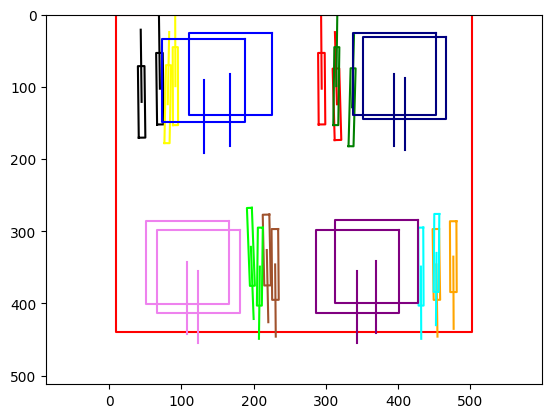

In [14]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scripts.utils import visual_noise, visual_noise_denoise

idx = 0
target_bbox = [(bbox_y, bbox_x, bbox_h + 1, bbox_w + 1, bbox_type.int().item()) for bbox_y, bbox_x, _, _, bbox_h, bbox_w, bbox_type in new_mask[idx]]

fig = plt.figure()

def update(tr):
    plt.cla()
    visual_noise(clean_scenepaths[idx], traj_to_return[tr], padding_mask[idx], target_bbox=target_bbox)
    # visual_noise_denoise(clean_scenepaths[idx], traj_to_return[tr], labels[idx], padding_mask[idx], target_bbox=target_bbox)

ani = animation.FuncAnimation(fig, update, frames=traj_to_return.shape[0] // 10, interval=1)
ani.save('sine_wave.gif')
plt.show()